<a href="https://www.kaggle.com/code/pritam1202/movie-recommender-engine?scriptVersionId=184262302" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install surprise

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [4]:
raw_data = pd.read_csv(r"/kaggle/input/netflix-movie-dataset/combined_data_1.txt",header = None, names=['CustId','Rating','Date'])
netflix = raw_data

In [5]:
netflix

,CustId,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26
...,...,...,...
24058258,2591364,2.0,2005-02-16
24058259,1791000,2.0,2005-02-10
24058260,512536,5.0,2005-07-27
24058261,988963,3.0,2005-12-20


In [6]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   CustId  object 
 1   Rating  float64
 2   Date    object 
dtypes: float64(1), object(2)
memory usage: 550.7+ MB


In [7]:
netflix.isnull().sum()

CustId       0
Rating    4499
Date      4499
dtype: int64

In [8]:
netflix.shape

(24058263, 3)

In [9]:
netflix.head()

,CustId,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


In [10]:
netflix.tail()

,CustId,Rating,Date
24058258,2591364,2.0,2005-02-16
24058259,1791000,2.0,2005-02-10
24058260,512536,5.0,2005-07-27
24058261,988963,3.0,2005-12-20
24058262,1704416,3.0,2004-06-02


In [11]:
netflix[netflix['Rating'].isnull()]

,CustId,Rating,Date
0,1:,NaN,NaN
548,2:,NaN,NaN
694,3:,NaN,NaN
2707,4:,NaN,NaN
2850,5:,NaN,NaN
...,...,...,...
24046714,4495:,NaN,NaN
24047329,4496:,NaN,NaN
24056849,4497:,NaN,NaN
24057564,4498:,NaN,NaN


In [12]:
netflix['CustId'].nunique()

475257

In [13]:
netflix.isnull().sum()

CustId       0
Rating    4499
Date      4499
dtype: int64

# Creating the dataset 

In [14]:
Null_val = pd.DataFrame(netflix['Rating'].isnull())
Null_val

,Rating
0,True
1,False
2,False
3,False
4,False
...,...
24058258,False
24058259,False
24058260,False
24058261,False


### Extracting the null values in ratings as they are placeholders for the required movie ids

In [15]:
Null_val = Null_val[Null_val['Rating'] == True].reset_index()
Null_val

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
...,...,...
4494,24046714,True
4495,24047329,True
4496,24056849,True
4497,24057564,True


In [16]:
#there is a total of 4499 movie ids
len(Null_val)

4499

### Creating a list of movie ids to merge with the final dataset and assigning values in ascending order starting from 1

In [17]:
movie_id = []
movie = 1
for i in range(len(Null_val)-1):
    temp = np.full(((Null_val['index'][i+1]-Null_val['index'][i]-1),1),movie) #assigning values of movies with shape same as the differnce between each True values 
    movie_id = np.append(movie_id,temp)
    movie+=1

movie

4499

In [18]:
# Values filled till movie id 4498
len(set(movie_id))

4498

In [19]:
len(movie_id)

24053336

In [20]:
#adding the last movie id 4499 to movie_id
last = np.full(((netflix.index[-1]-Null_val['index'][len(Null_val)-1]),1),movie)
movie_id = np.append(movie_id,last)
len(set(movie_id))

4499

In [21]:
len(movie_id)

24053764

In [22]:
#removing the null values and the Date column
netflix = netflix.dropna().drop('Date',axis=1)
netflix.shape

(24053764, 2)

In [23]:
netflix

,CustId,Rating
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
5,823519,3.0
...,...,...
24058258,2591364,2.0
24058259,1791000,2.0
24058260,512536,5.0
24058261,988963,3.0


### Adding the movie ids to the netflix dataset 

In [24]:
netflix['MovieId'] = movie_id.astype(int)
netflix['CustId'] = netflix['CustId'].astype(int)
netflix

,CustId,Rating,MovieId
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


In [25]:
#importing the movie names
movie_name = pd.read_csv(r'/kaggle/input/netflix-movie-dataset/movie_titles.csv',header=None,names=['MovieId',"Release Year",'Movie_name'],usecols=[0,1,2])
movie_name.head()

,MovieId,Release Year,Movie_name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [26]:
#setting movie_id to index for filtering the movie names from 1 to 4499
movie_name.set_index('MovieId',inplace=True)
movie_name

,Release Year,Movie_name
MovieId,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
...,...,...
17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17767,2004.0,Fidel Castro: American Experience
17768,2000.0,Epoch


In [27]:
movie_name.duplicated().sum()

16

In [28]:
movie_name[movie_name.duplicated()]

,Release Year,Movie_name
MovieId,,
4005,1993.0,Dr. Quinn
5223,1999.0,Girl
5712,1999.0,The Hunchback of Notre Dame
6063,1962.0,The Lucy Show
7351,2002.0,Pinocchio
9629,2002.0,Stranded
9827,2004.0,Frankenstein
10789,2000.0,Second Skin
11089,2001.0,Monsters


In [29]:
#extracting the required movies
movie_name = movie_name[0:4499]
movie_name

,Release Year,Movie_name
MovieId,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
...,...,...
4495,2002.0,Clifford: Happy Birthday Clifford / Puppy Love
4496,1993.0,Farewell My Concubine
4497,1990.0,Texasville


In [30]:
movie_name.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4499 entries, 1 to 4499
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Release Year  4499 non-null   float64
 1   Movie_name    4499 non-null   object 
dtypes: float64(1), object(1)
memory usage: 105.4+ KB


In [31]:
movie_name.duplicated().sum()

1

In [32]:
movie_name['Movie_name'].duplicated().sum()

28

In [33]:
movie_name.reset_index(inplace = True)
movie_name

,MovieId,Release Year,Movie_name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
4494,4495,2002.0,Clifford: Happy Birthday Clifford / Puppy Love
4495,4496,1993.0,Farewell My Concubine
4496,4497,1990.0,Texasville
4497,4498,2000.0,Gonin


In [34]:
movie_name['Release Year'] = movie_name['Release Year'].astype(int)
movie_name['Movie_name'] = movie_name['Movie_name'].astype(str)
movie_name.head()

,MovieId,Release Year,Movie_name
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


### Adding the movie genres

In [35]:
#importing Genre dataset
genre_data = pd.read_csv("/kaggle/input/netflix-movie-dataset/movies.csv")
genre_data.head()

,title,genres
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji (1995),Adventure|Children|Fantasy
2,Grumpier Old Men (1995),Comedy|Romance
3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,Father of the Bride Part II (1995),Comedy


In [36]:
genre_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   27278 non-null  object
 1   genres  27278 non-null  object
dtypes: object(2)
memory usage: 426.3+ KB


In [37]:
genre_data.rename(columns={'title':'Movie_name', 'genres':'Genres'}, inplace=True)
genre_data

,Movie_name,Genres
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji (1995),Adventure|Children|Fantasy
2,Grumpier Old Men (1995),Comedy|Romance
3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,Father of the Bride Part II (1995),Comedy
...,...,...
27273,Kein Bund für's Leben (2007),Comedy
27274,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,The Pirates (2014),Adventure
27276,Rentun Ruusu (2001),(no genres listed)


In [38]:
genre_data['Movie_name'] = genre_data['Movie_name'].str.strip()

In [39]:
genre_data.duplicated().sum()

6

In [40]:
genre_data[genre_data.duplicated()]

,Movie_name,Genres
15826,Offside (2006),Comedy|Drama
20653,"Girl, The (2012)",Drama
24437,Beneath (2013),Horror
25886,Clear History (2013),Comedy
26850,Johnny Express (2014),Animation|Comedy|Sci-Fi
27064,Darling (2007),Drama


In [41]:
genre_data['Movie_name'].duplicated().sum()

16

In [42]:
genre_data[genre_data['Movie_name'].duplicated()]

,Movie_name,Genres
9135,Emma (1996),Romance
9150,Men with Guns (1997),Drama
13269,War of the Worlds (2005),Action|Sci-Fi
13354,Hamlet (2000),Drama
13572,Chaos (2005),Crime|Drama|Horror
15826,Offside (2006),Comedy|Drama
16827,Blackout (2007),Drama
20653,"Girl, The (2012)",Drama
24064,"20,000 Leagues Under the Sea (1997)",Romance|Sci-Fi
24092,Aladdin (1992),Adventure|Animation|Children|Comedy|Fantasy


The duplicates are not present in our set of considered mmovie IDs

In [43]:
genre_data.drop_duplicates(keep = 'first', inplace = True)
genre_data.shape

(27272, 2)

In [44]:
movie_name.head()

,MovieId,Release Year,Movie_name
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


In [45]:
movie_name['Movie_name'] = movie_name['Movie_name'] + ' (' + movie_name['Release Year'].astype(str) + ')'
movie_name.head()

,MovieId,Release Year,Movie_name
0,1,2003,Dinosaur Planet (2003)
1,2,2004,Isle of Man TT 2004 Review (2004)
2,3,1997,Character (1997)
3,4,1994,Paula Abdul's Get Up & Dance (1994)
4,5,2004,The Rise and Fall of ECW (2004)


In [46]:
#updating the name dataset with genre
movie_name = pd.merge(movie_name, genre_data, on=["Movie_name"], how='left')
movie_name

,MovieId,Release Year,Movie_name,Genres
0,1,2003,Dinosaur Planet (2003),NaN
1,2,2004,Isle of Man TT 2004 Review (2004),NaN
2,3,1997,Character (1997),NaN
3,4,1994,Paula Abdul's Get Up & Dance (1994),NaN
4,5,2004,The Rise and Fall of ECW (2004),NaN
...,...,...,...,...
4495,4495,2002,Clifford: Happy Birthday Clifford / Puppy Love...,NaN
4496,4496,1993,Farewell My Concubine (1993),NaN
4497,4497,1990,Texasville (1990),Drama
4498,4498,2000,Gonin (2000),NaN


In [47]:
movie_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MovieId       4500 non-null   int64 
 1   Release Year  4500 non-null   int64 
 2   Movie_name    4500 non-null   object
 3   Genres        1139 non-null   object
dtypes: int64(2), object(2)
memory usage: 140.8+ KB


In [48]:
movie_name[movie_name['MovieId'].duplicated()]

,MovieId,Release Year,Movie_name,Genres
903,903,2000,Hamlet (2000),Drama


In [49]:
movie_name[movie_name['MovieId']==903]

,MovieId,Release Year,Movie_name,Genres
902,903,2000,Hamlet (2000),Crime|Drama|Romance|Thriller
903,903,2000,Hamlet (2000),Drama


In [50]:
# Dropping the second occurance of Hamlet as the genre drama is already included in the previous one
movie_name.drop_duplicates(keep = 'first', inplace = True, subset = 'MovieId')
movie_name['MovieId'].duplicated().sum()

0

In [51]:
movie_name['Movie_name'] = movie_name['Movie_name'].str[0:-7:1]
movie_name

,MovieId,Release Year,Movie_name,Genres
0,1,2003,Dinosaur Planet,NaN
1,2,2004,Isle of Man TT 2004 Review,NaN
2,3,1997,Character,NaN
3,4,1994,Paula Abdul's Get Up & Dance,NaN
4,5,2004,The Rise and Fall of ECW,NaN
...,...,...,...,...
4495,4495,2002,Clifford: Happy Birthday Clifford / Puppy Love,NaN
4496,4496,1993,Farewell My Concubine,NaN
4497,4497,1990,Texasville,Drama
4498,4498,2000,Gonin,NaN


### Merging the names and genre to netflix dataset for creating the ***Final dataset***

In [52]:
netflix

,CustId,Rating,MovieId
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


In [53]:
netflix = pd.merge(netflix,movie_name,on='MovieId',how='left')
netflix

,CustId,Rating,MovieId,Release Year,Movie_name,Genres
0,1488844,3.0,1,2003,Dinosaur Planet,NaN
1,822109,5.0,1,2003,Dinosaur Planet,NaN
2,885013,4.0,1,2003,Dinosaur Planet,NaN
3,30878,4.0,1,2003,Dinosaur Planet,NaN
4,823519,3.0,1,2003,Dinosaur Planet,NaN
...,...,...,...,...,...,...
24053759,2591364,2.0,4499,2002,In My Skin,NaN
24053760,1791000,2.0,4499,2002,In My Skin,NaN
24053761,512536,5.0,4499,2002,In My Skin,NaN
24053762,988963,3.0,4499,2002,In My Skin,NaN


# Analysis

In [54]:
netflix['CustId'].nunique()

470758

In [55]:
netflix['Rating'].value_counts()

Rating
4.0    8085741
3.0    6904181
5.0    5506583
2.0    2439073
1.0    1118186
Name: count, dtype: int64

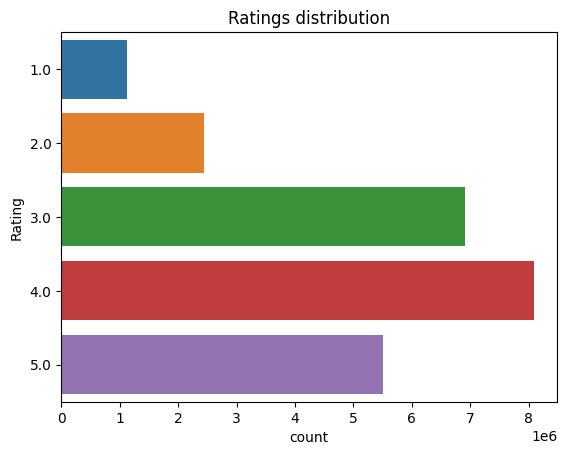

In [56]:
sns.countplot(data = netflix, y = 'Rating')
plt.title("Ratings distribution")
plt.show()

In [57]:
netflix['Release Year'].isnull().sum()

0

In [58]:
netflix['Release Year'].nunique()

90

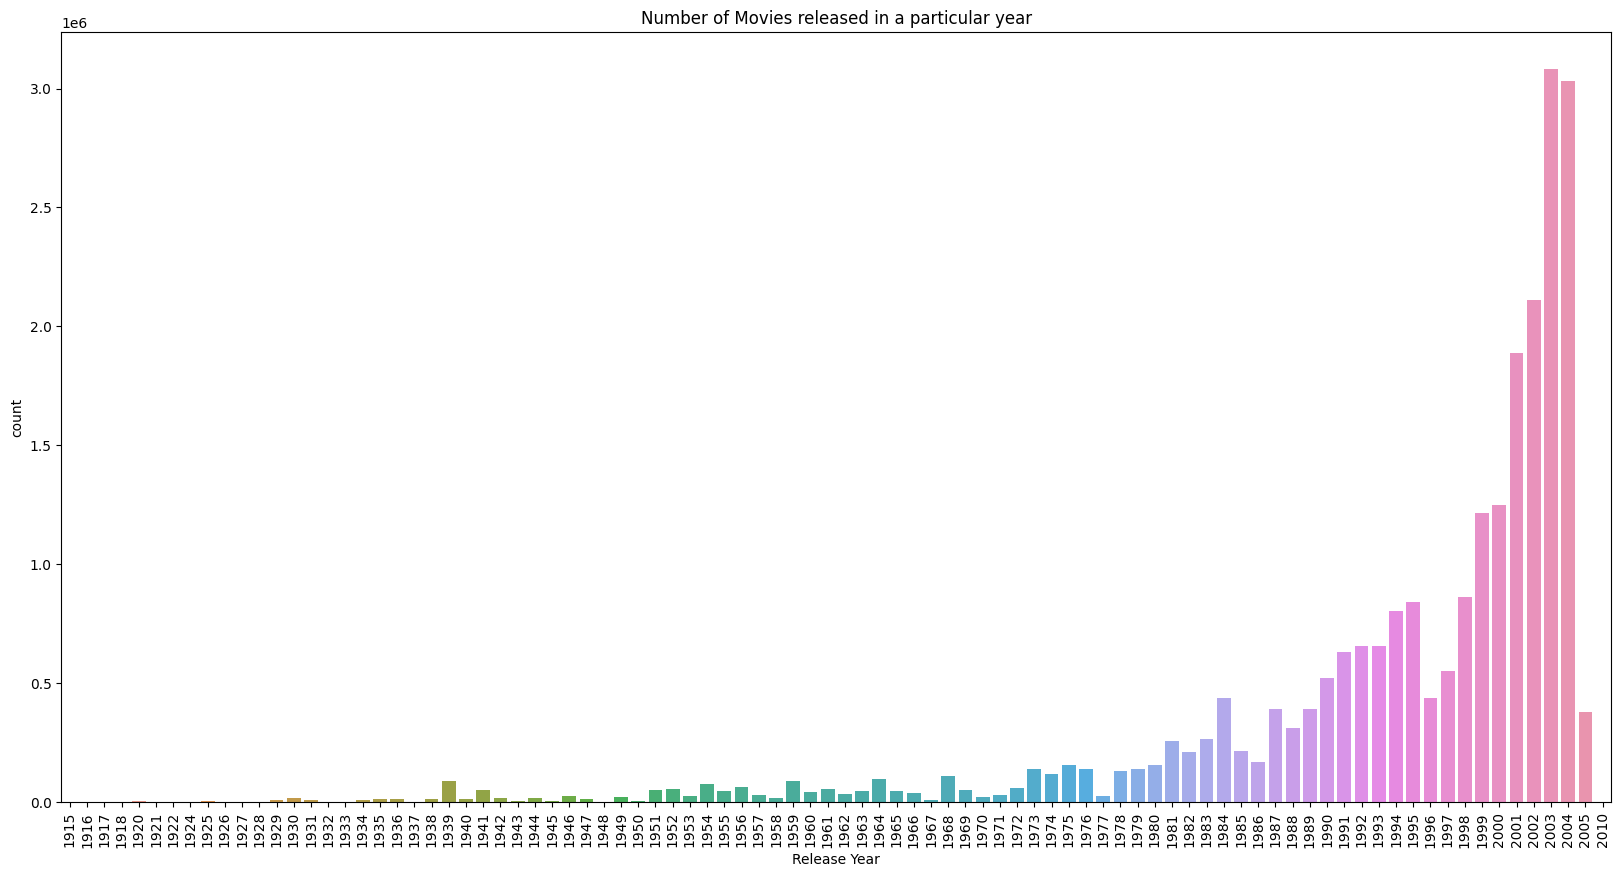

In [59]:
plt.figure(figsize=(20,10))
sns.countplot(data = netflix, x = "Release Year")
plt.title("Number of Movies released in a particular year")
plt.xticks(rotation = 90)
plt.show()

In [60]:
netflix['Movie_name'].nunique()

4471

In [61]:
netflix['Genres'].isnull().sum()

9968232

In [62]:
# Count of ratings for each movie
netflix.groupby('Movie_name')['Rating'].agg(['count']).sort_values(by=['count'],ascending=False)

,count
Movie_name,
Pirates of the Caribbean: The Curse of the Black Pearl,193941
What Women Want,162597
Bruce Almighty,160454
The Italian Job,156183
American Beauty,154832
...,...
Ghost Hunters: Season 1,44
Haven,43
Expo: Magic of the White City,42


In [63]:
# Count of 5 star ratings for each movie
netflix[netflix['Rating']==5].groupby('Movie_name')['Rating'].agg(['count']).sort_values(by=['count'],ascending=False)

,count
Movie_name,
Lord of the Rings: The Fellowship of the Ring,94655
Pirates of the Caribbean: The Curse of the Black Pearl,82549
Finding Nemo (Widescreen),79447
The Sixth Sense,74790
Braveheart,71154
...,...
Horror Vision,1
The Blackout,1
Postmortem,1


In [64]:
# Movies with no 5 start rating
print("Number of movies with no 5 star rating --> ", netflix['Movie_name'][~netflix['Movie_name'].isin(netflix[netflix['Rating']==5]['Movie_name'])].nunique())
pd.DataFrame(netflix['Movie_name'][~netflix['Movie_name'].isin(netflix[netflix['Rating']==5]['Movie_name'])].unique(), columns = ['Name'])

Number of movies with no 5 star rating -->  3


,Name
0,Option Zero
1,Avia Vampire Hunter
2,Bram Stoker's: To Die For


In [65]:
# Count of 1 star rating for each movie
netflix[netflix['Rating']==1].groupby('Movie_name')['Rating'].agg(['count']).sort_values(by=['count'],ascending=False)

,count
Movie_name,
Napoleon Dynamite,13365
The Wedding Planner,12194
What Women Want,8855
Patch Adams,8375
About Schmidt,8334
...,...
Ghost Hunters: Season 1,2
Casino: 10th Anniversary Edition: Bonus Material,2
Girls Bravo,2


In [66]:
# Movies with no 1 start rating
print("Number of movies with no 1 star rating --> ", netflix['Movie_name'][~netflix['Movie_name'].isin(netflix[netflix['Rating']==1]['Movie_name'])].nunique())
pd.DataFrame(netflix['Movie_name'][~netflix['Movie_name'].isin(netflix[netflix['Rating']==1]['Movie_name'])].unique(), columns = ['Name'])

Number of movies with no 1 star rating -->  1


,Name
0,Lord of the Rings: The Return of the King: Ext...


In [67]:
# Average rating of each movie
netflix.groupby('Movie_name')['Rating'].agg(['mean']).sort_values(by=['mean'],ascending=False)

,mean
Movie_name,
Lost: Season 1,4.670989
Ghost in the Shell: Stand Alone Complex: 2nd Gig,4.586364
The Simpsons: Season 6,4.581296
Inu-Yasha,4.554434
Lord of the Rings: The Return of the King: Extended Edition: Bonus Material,4.552000
...,...
The Horror Within,1.496241
Half-Caste,1.487395
Dark Harvest 2: The Maize,1.452381


In [68]:
#Rating count for each customer
netflix.groupby('CustId')['Rating'].agg(['count']).sort_values(by=['count'],ascending=False)

,count
CustId,
305344,4467
387418,4422
2439493,4195
1664010,4019
2118461,3769
...,...
1605874,1
2429614,1
1605861,1


In [69]:
#5 star rating count for each customer
netflix[netflix['Rating']==5].groupby('CustId')['Rating'].agg(['count']).sort_values(by=['count'],ascending=False)

,count
CustId,
1664010,2060
794999,1291
2118461,1243
447759,976
716173,861
...,...
1573545,1
495881,1
1949471,1


In [70]:
#1 star rating count for each customer
netflix[netflix['Rating']==1].groupby('CustId')['Rating'].agg(['count']).sort_values(by=['count'],ascending=False)

,count
CustId,
2439493,3851
305344,2416
1639792,2139
1461435,2068
387418,1955
...,...
839290,1
226179,1
226209,1


In [71]:
# Count of ratings for each genres set
netflix.groupby('Genres')['Rating'].agg(['count']).sort_values(by=['count'],ascending=False)

,count
Genres,
Comedy,1460558
Drama,1169475
Comedy|Romance,1092255
Comedy|Drama|Romance,1038793
Comedy|Drama,736084
...,...
Animation|Children|Comedy|Musical,112
Comedy|Drama|Western,107
Animation|Comedy,85


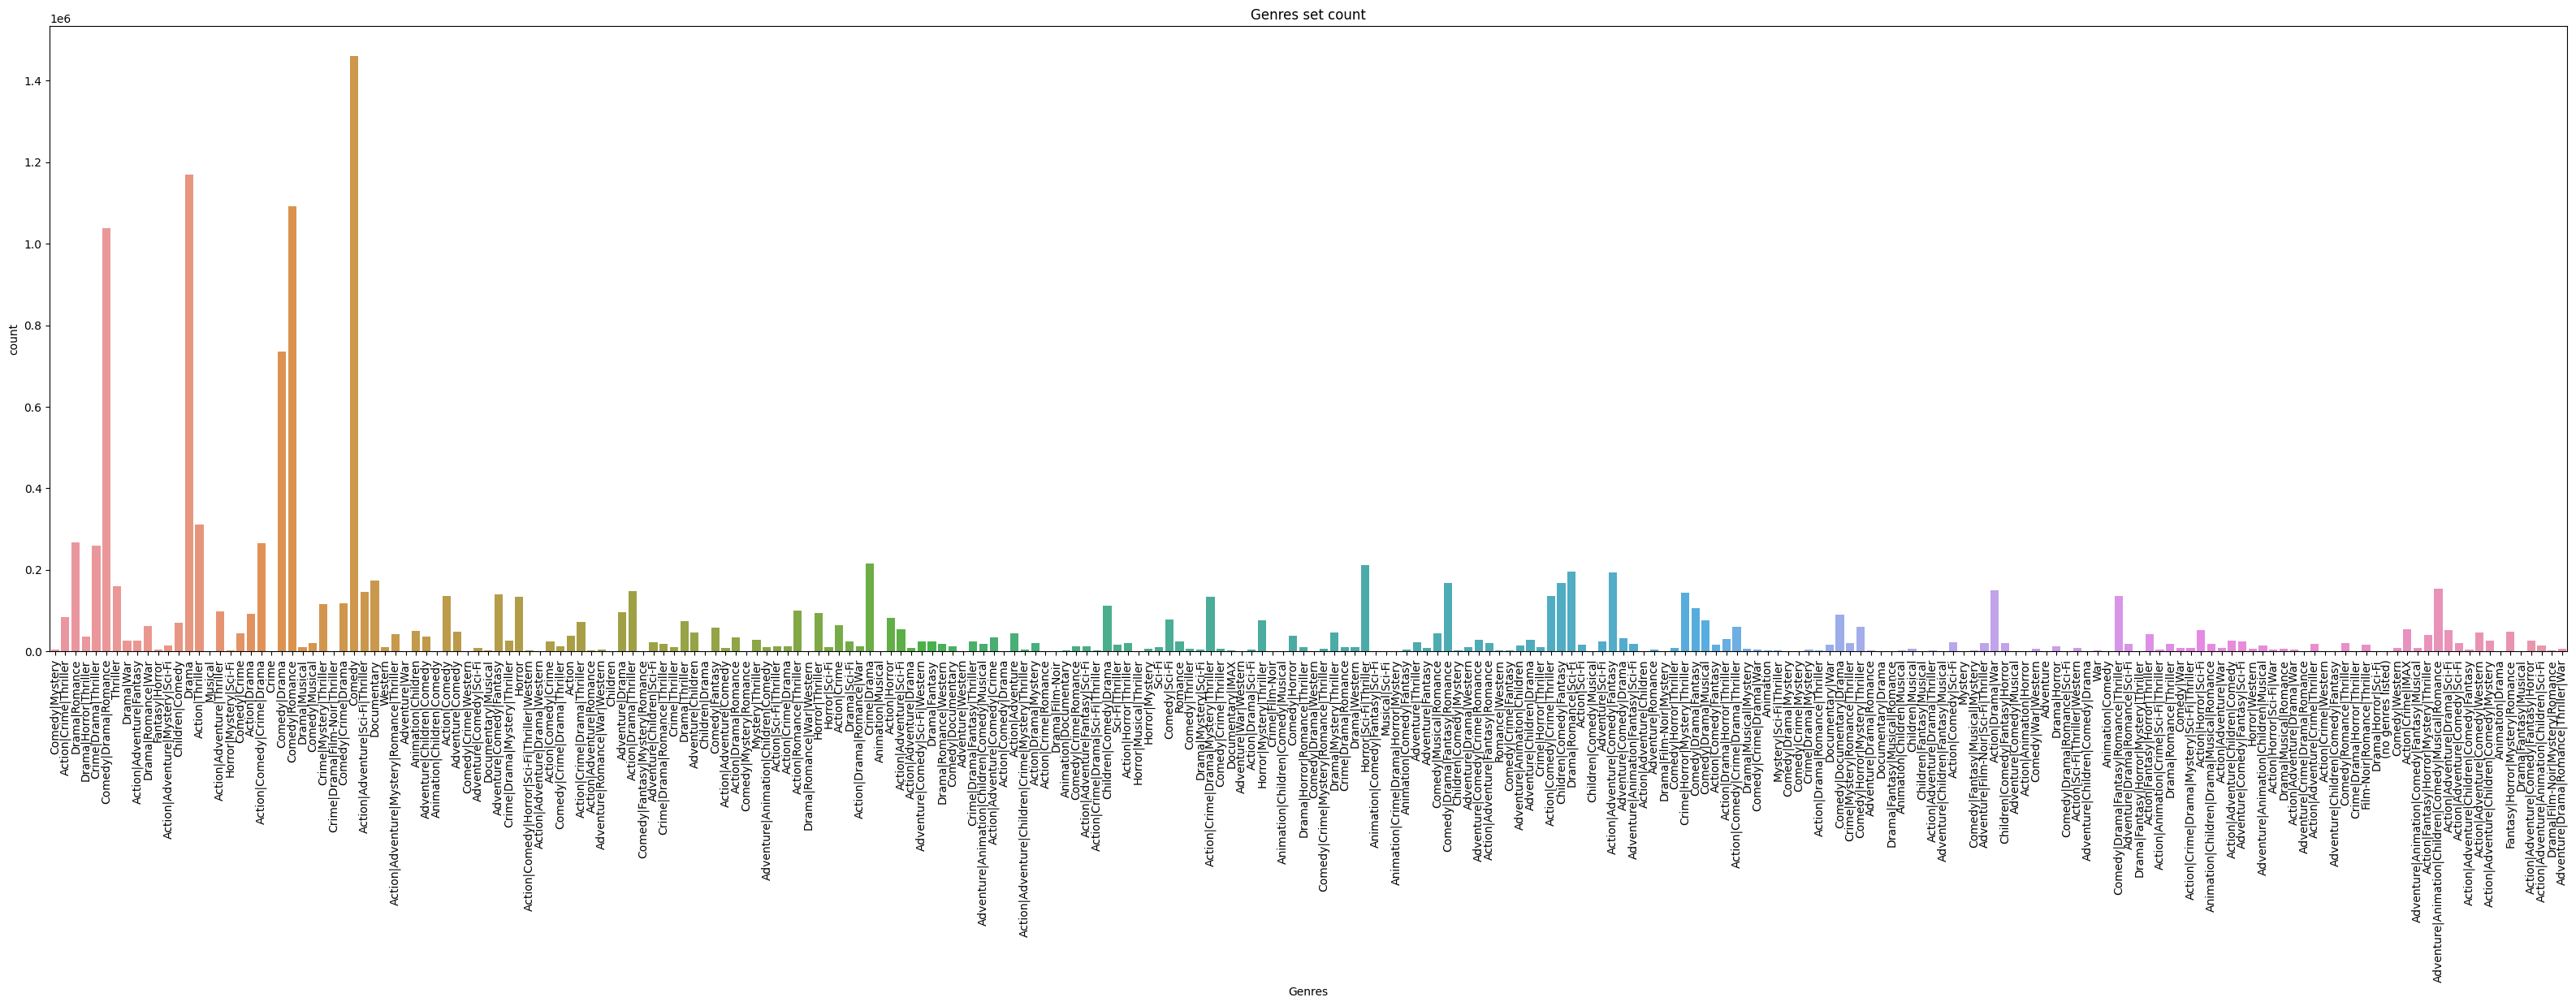

In [72]:
plt.figure(figsize=(40,10))
sns.countplot(data = netflix, x = "Genres")
plt.title("Genres set count")
plt.xticks(rotation = 90)
plt.show()

In [73]:
# Count of 5 star ratings for each genres set
netflix[netflix['Rating']==5].groupby('Genres')['Rating'].agg(['count']).sort_values(by=['count'],ascending=False)

,count
Genres,
Drama,281527
Comedy,272802
Comedy|Drama|Romance,233176
Comedy|Romance,190188
Comedy|Drama,143164
...,...
Animation|Comedy,9
Drama|Fantasy|Horror|Mystery|Thriller,6
Action|Crime|Western,6


In [74]:
# Genres set with no 5 start rating
print("Number of genres with no 5 star rating --> ", netflix['Genres'][~netflix['Genres'].isin(netflix[netflix['Rating']==5]['Genres'])].nunique())
pd.DataFrame(netflix['Genres'][~netflix['Genres'].isin(netflix[netflix['Rating']==5]['Genres'])].unique(), columns = ['Name'])

Number of genres with no 5 star rating -->  0


,Name


In [75]:
# Count of 1 star rating for each genres set
netflix[netflix['Rating']==1].groupby('Genres')['Rating'].agg(['count']).sort_values(by=['count'],ascending=False)

,count
Genres,
Comedy,82495
Comedy|Romance,47141
Drama,41962
Comedy|Drama|Romance,38479
Comedy|Drama,38396
...,...
Documentary|Drama,11
Action|Adventure|Drama|Western,10
Drama|Fantasy|Musical,8


In [76]:
# Genres with no 1 start rating
print("Number of genres set with no 1 star rating --> ", netflix['Genres'][~netflix['Genres'].isin(netflix[netflix['Rating']==1]['Genres'])].nunique())
pd.DataFrame(netflix['Genres'][~netflix['Genres'].isin(netflix[netflix['Rating']==1]['Genres'])].unique(), columns = ['Name'])

Number of genres set with no 1 star rating -->  0


,Name


In [77]:
# Average rating of each genre set
netflix.groupby('Genres')['Rating'].agg(['mean']).sort_values(by=['mean'],ascending=False)

,mean
Genres,
Animation|Comedy|Fantasy|Sci-Fi,4.360746
Action|Crime|IMAX,4.236699
Action|Drama|War,4.230531
Action|Adventure|Mystery|Romance|Thriller,4.157901
Action|Adventure|Comedy|Fantasy,4.153908
...,...
Action|Crime|Western,2.369565
Action|Horror|Sci-Fi|War,2.264801
Crime,2.167939


## Data cleaning 
### (for resource optimization)

In [78]:
#Movies with ratings count less than 70 percentile
movie_cut_off = round(netflix.groupby('MovieId')['Rating'].agg(['count'])['count'].quantile(0.7),0)
drop_movie_list = netflix.groupby('MovieId')['Rating'].agg(['count'])[netflix.groupby('MovieId')['Rating'].agg(['count'])['count'] < movie_cut_off].index
drop_movie_list

Index([   1,    2,    4,    5,    6,    7,    9,   10,   11,   12,
       ...
       4484, 4486, 4487, 4489, 4491, 4494, 4495, 4497, 4498, 4499],
      dtype='int64', name='MovieId', length=3149)

In [79]:
#Customer that have given rating less than 70 percentile
cust_cut_off = round(netflix.groupby('CustId')['Rating'].agg(['count'])['count'].quantile(0.7),0)
drop_cust_list = netflix.groupby('CustId')['Rating'].agg(['count'])[netflix.groupby('CustId')['Rating'].agg(['count'])['count'] < cust_cut_off].index
drop_cust_list

Index([      8,      10,      25,      33,      42,      59,      83,      87,
            94,     116,
       ...
       2649343, 2649351, 2649375, 2649376, 2649379, 2649384, 2649401, 2649404,
       2649409, 2649421],
      dtype='int64', name='CustId', length=327300)

In [80]:
netflix.shape

(24053764, 6)

In [81]:
#Dropping customer and movie that are in drop list
netflix_movies = netflix[(~netflix['MovieId'].isin(drop_movie_list))&(~netflix['CustId'].isin(drop_cust_list))]
netflix_movies.shape

(17337458, 6)

# Model fitting and rating prediction

In [82]:
from surprise import Reader, SVD, Dataset
from surprise.model_selection import cross_validate

In [83]:
netflix_movies.head()

,CustId,Rating,MovieId,Release Year,Movie_name,Genres
693,712664,5.0,3,1997,Character,NaN
694,1331154,4.0,3,1997,Character,NaN
695,2632461,3.0,3,1997,Character,NaN
696,44937,5.0,3,1997,Character,NaN
697,656399,4.0,3,1997,Character,NaN


## Model fitting and cross validating

In [84]:
#arranging data to feed the SVD model
reader = Reader()
model_data = Dataset.load_from_df(netflix_movies[['CustId','MovieId','Rating']],reader)
model_data

In [85]:
#model fitting and cross validation
model = SVD()
cross_validate(model,model_data,measures=['RMSE','MAE'],cv=4)

{'test_rmse': array([0.85115634, 0.85078396, 0.85139534, 0.85189145]),
 'test_mae': array([0.66093469, 0.66071975, 0.66095236, 0.66137075]),
 'fit_time': (313.03344893455505,
  294.40102219581604,
  293.61611127853394,
  293.9249882698059),
 'test_time': (96.93942856788635,
  75.07417893409729,
  73.0224347114563,
  77.2924132347107)}

## Predictions

### Prediction for a random user

In [86]:
random_user = netflix_movies['CustId'].sample(n=1).iloc[0]
random_user

2641459

In [87]:
#predictng ratings for random user
user = movie_name[~movie_name['MovieId'].isin(drop_movie_list)]
user['Estimated rating'] = user['MovieId'].apply(lambda x: model.predict(random_user,x).est)
user

,MovieId,Release Year,Movie_name,Genres,Estimated rating
2,3,1997,Character,NaN,3.153772
7,8,2004,What the #$*! Do We Know!?,NaN,3.530328
15,16,1996,Screamers,NaN,3.636099
16,17,2005,7 Seconds,Action|Crime|Thriller,3.421402
17,18,1994,Immortal Beloved,Drama|Romance,3.928749
...,...,...,...,...,...
4488,4488,2000,Wonder Boys,Comedy|Drama,3.283187
4490,4490,2004,Ned Kelly,NaN,3.395697
4492,4492,2004,Club Dread,Comedy|Horror,2.755808
4493,4493,2003,Ju-on: The Grudge,NaN,2.872267


In [88]:
#RMSE of prediction
ratings = netflix_movies[['MovieId','Rating']][netflix_movies['CustId']==random_user].sort_values(by='MovieId',ascending=False)
pred = user[['MovieId','Estimated rating']][user['MovieId'].isin(ratings['MovieId'])].sort_values(by='MovieId',ascending=False)
MSE = metrics.mean_squared_error(ratings['Rating'],pred['Estimated rating'])
RMSE = np.sqrt(metrics.mean_squared_error(ratings['Rating'],pred['Estimated rating']))
print(f'The RMSE of model for user {random_user} is --> ', RMSE)

The RMSE of model for user 2641459 is -->  0.5915436331045231


### Prediction for customer with highest count of ratings

In [89]:
#predictng ratings for user 305344
user_305344 = movie_name[~movie_name['MovieId'].isin(drop_movie_list)]
user_305344['Estimated rating'] = user_305344['MovieId'].apply(lambda x: model.predict(305344,x).est)
user_305344

,MovieId,Release Year,Movie_name,Genres,Estimated rating
2,3,1997,Character,NaN,2.300145
7,8,2004,What the #$*! Do We Know!?,NaN,1.641486
15,16,1996,Screamers,NaN,2.613660
16,17,2005,7 Seconds,Action|Crime|Thriller,1.390121
17,18,1994,Immortal Beloved,Drama|Romance,2.654356
...,...,...,...,...,...
4488,4488,2000,Wonder Boys,Comedy|Drama,2.422972
4490,4490,2004,Ned Kelly,NaN,2.214668
4492,4492,2004,Club Dread,Comedy|Horror,1.000000
4493,4493,2003,Ju-on: The Grudge,NaN,1.000000


In [90]:
#RMSE of prediction
ratings_305344 = netflix_movies[['MovieId','Rating']][netflix_movies['CustId']==305344].sort_values(by='MovieId',ascending=False)
pred_305344 = user_305344[['MovieId','Estimated rating']][user_305344['MovieId'].isin(ratings_305344['MovieId'])].sort_values(by='MovieId',ascending=False)
RMSE = np.sqrt(metrics.mean_squared_error(ratings_305344['Rating'],pred_305344['Estimated rating']))
print('The RMSE of model for user 305344 is --> ', RMSE)

The RMSE of model for user 305344 is -->  1.0448598431813978


### Prediction for customer with highest count of 5 star ratings

In [91]:
#predictng ratings for user 1664010
user_1664010 = movie_name[~movie_name['MovieId'].isin(drop_movie_list)]
user_1664010['Estimated rating'] = user_1664010['MovieId'].apply(lambda x: model.predict(1664010,x).est)
user_1664010

,MovieId,Release Year,Movie_name,Genres,Estimated rating
2,3,1997,Character,NaN,4.801258
7,8,2004,What the #$*! Do We Know!?,NaN,4.319318
15,16,1996,Screamers,NaN,5.000000
16,17,2005,7 Seconds,Action|Crime|Thriller,4.690580
17,18,1994,Immortal Beloved,Drama|Romance,5.000000
...,...,...,...,...,...
4488,4488,2000,Wonder Boys,Comedy|Drama,4.913001
4490,4490,2004,Ned Kelly,NaN,4.595320
4492,4492,2004,Club Dread,Comedy|Horror,4.483500
4493,4493,2003,Ju-on: The Grudge,NaN,4.615250


In [92]:
#RMSE of prediction
ratings_1664010 = netflix_movies[['MovieId','Rating']][netflix_movies['CustId']==1664010].sort_values(by='MovieId',ascending=False)
pred_1664010 = user_1664010[['MovieId','Estimated rating']][user_1664010['MovieId'].isin(ratings_1664010['MovieId'])].sort_values(by='MovieId',ascending=False)
RMSE = np.sqrt(metrics.mean_squared_error(ratings_1664010['Rating'],pred_1664010['Estimated rating']))
print('The RMSE of model for user 1664010 is --> ', RMSE)

The RMSE of model for user 1664010 is -->  0.34083676586619316


### Prediction for customer with highest count of 1 star ratings

In [93]:
#predictng ratings for user 2439493
user_2439493 = movie_name[~movie_name['MovieId'].isin(drop_movie_list)]
user_2439493['Estimated rating'] = user_2439493['MovieId'].apply(lambda x: model.predict(2439493,x).est)
user_2439493

,MovieId,Release Year,Movie_name,Genres,Estimated rating
2,3,1997,Character,NaN,1.000000
7,8,2004,What the #$*! Do We Know!?,NaN,1.000000
15,16,1996,Screamers,NaN,1.030483
16,17,2005,7 Seconds,Action|Crime|Thriller,1.721321
17,18,1994,Immortal Beloved,Drama|Romance,1.417409
...,...,...,...,...,...
4488,4488,2000,Wonder Boys,Comedy|Drama,1.422588
4490,4490,2004,Ned Kelly,NaN,1.470419
4492,4492,2004,Club Dread,Comedy|Horror,1.000000
4493,4493,2003,Ju-on: The Grudge,NaN,1.000000


In [94]:
#RMSE of prediction
ratings_2439493 = netflix_movies[['MovieId','Rating']][netflix_movies['CustId']==2439493].sort_values(by='MovieId',ascending=False)
pred_2439493 = user_2439493[['MovieId','Estimated rating']][user_2439493['MovieId'].isin(ratings_2439493['MovieId'])].sort_values(by='MovieId',ascending=False)
MSE = metrics.mean_squared_error(ratings_2439493['Rating'],pred_2439493['Estimated rating'])
RMSE = np.sqrt(metrics.mean_squared_error(ratings_2439493['Rating'],pred_2439493['Estimated rating']))
print('The RMSE of model for user 2439493 is --> ', RMSE)

The RMSE of model for user 2439493 is -->  0.8302702008228733
